In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from scipy import stats

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('~/.kaggle/train.csv')
df_train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [4]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7905.0,3952.000000,2282.121272,0.00,1976.00,3952.00,5928.00,7904.00
N_Days,7905.0,2030.173308,1094.233744,41.00,1230.00,1831.00,2689.00,4795.00
Age,7905.0,18373.146490,3679.958739,9598.00,15574.00,18713.00,20684.00,28650.00
Bilirubin,7905.0,2.594485,3.812960,0.30,0.70,1.10,3.00,28.00
Cholesterol,7905.0,350.561923,195.379344,120.00,248.00,298.00,390.00,1775.00
Albumin,7905.0,3.548323,0.346171,1.96,3.35,3.58,3.77,4.64
Copper,7905.0,83.902846,75.899266,4.00,39.00,63.00,102.00,588.00
Alk_Phos,7905.0,1816.745250,1903.750657,289.00,834.00,1181.00,1857.00,13862.40
SGOT,7905.0,114.604602,48.790945,26.35,75.95,108.50,137.95,457.25
Tryglicerides,7905.0,115.340164,52.530402,33.00,84.00,104.00,139.00,598.00


In [5]:
df_test = pd.read_csv('~/.kaggle/test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5271 non-null   int64  
 1   N_Days         5271 non-null   int64  
 2   Drug           5271 non-null   object 
 3   Age            5271 non-null   int64  
 4   Sex            5271 non-null   object 
 5   Ascites        5271 non-null   object 
 6   Hepatomegaly   5271 non-null   object 
 7   Spiders        5271 non-null   object 
 8   Edema          5271 non-null   object 
 9   Bilirubin      5271 non-null   float64
 10  Cholesterol    5271 non-null   float64
 11  Albumin        5271 non-null   float64
 12  Copper         5271 non-null   float64
 13  Alk_Phos       5271 non-null   float64
 14  SGOT           5271 non-null   float64
 15  Tryglicerides  5271 non-null   float64
 16  Platelets      5271 non-null   float64
 17  Prothrombin    5271 non-null   float64
 18  Stage   

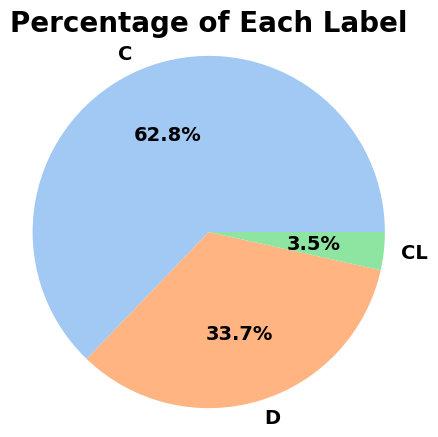

In [6]:
# define Seaborn color palette to use 
palette_color = sns.color_palette('pastel') 
label_counts = df_train['Status'].value_counts()

# plotting data on chart 
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, colors=palette_color, autopct='%1.1f%%', textprops={'fontsize': 14, 'fontweight': 'bold'}) 
  
plt.title('Percentage of Each Label', fontsize=20, fontweight='bold')
plt.axis('equal')
plt.show()

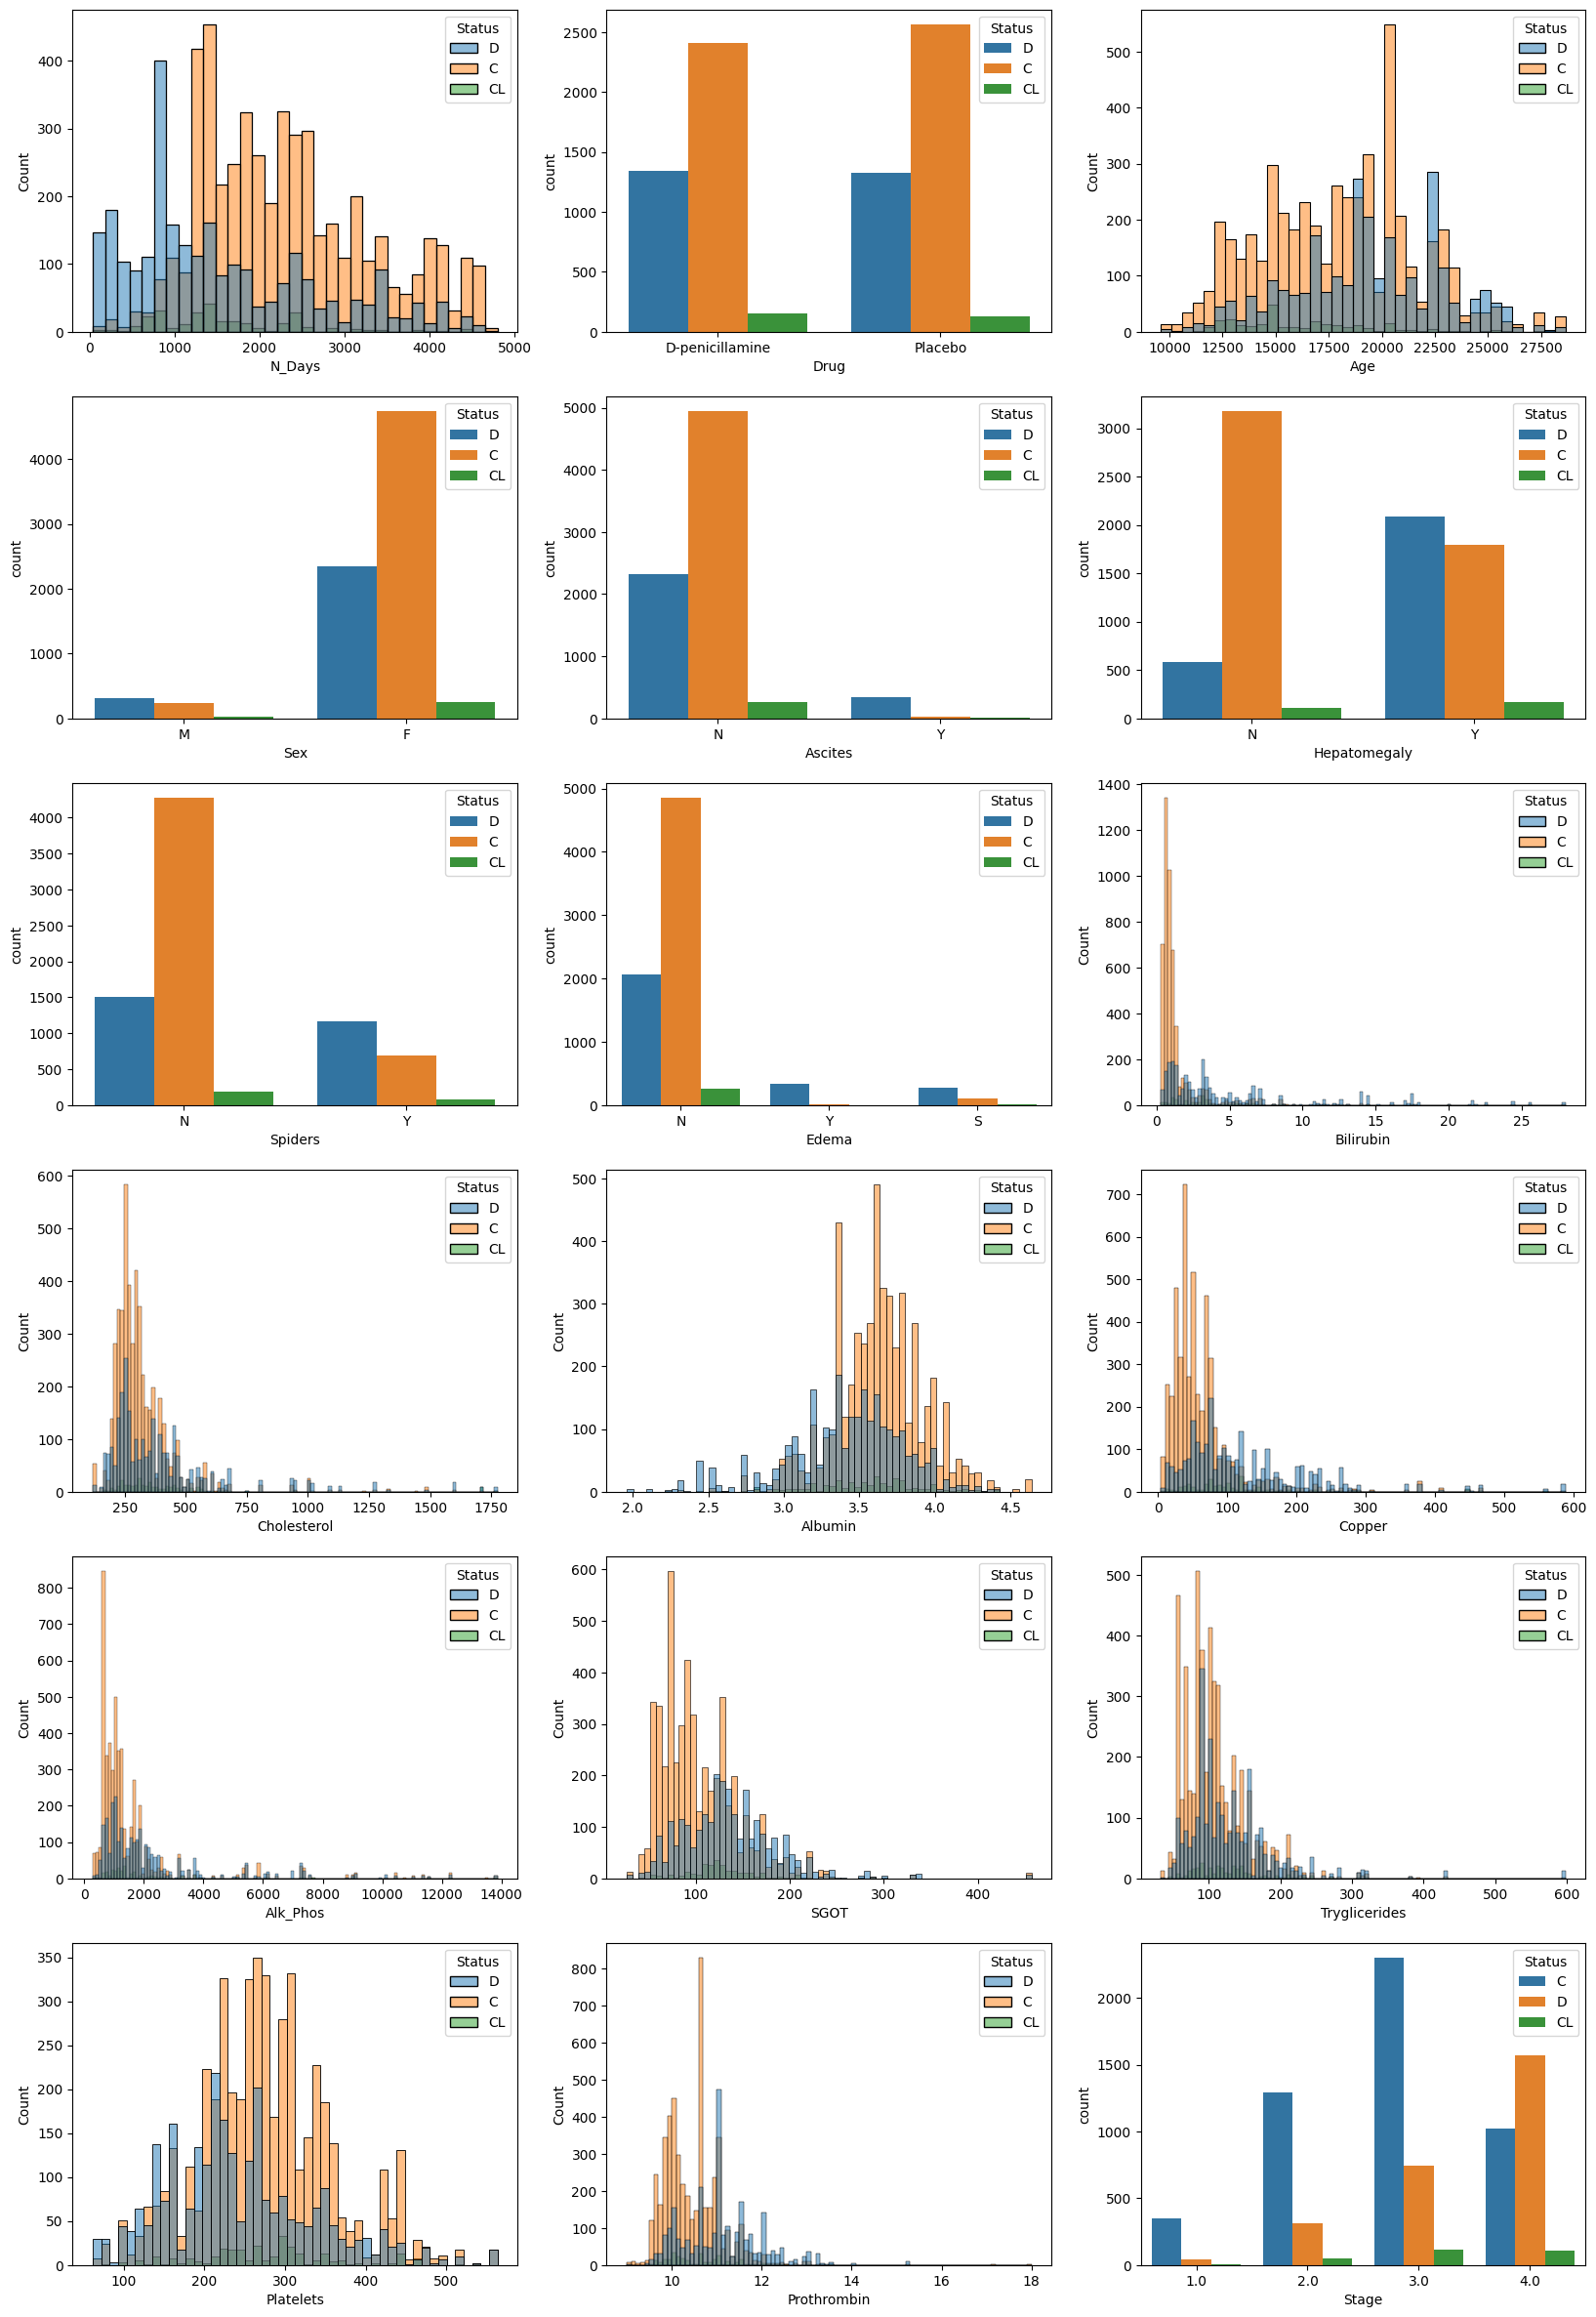

In [7]:
# visualizing feature distribution
fig, axes = plt.subplots(6,3, figsize=(20,30))

for feature, ax in zip(df_train.columns[1:], axes.flatten()):
    if df_train[feature].dtype == 'object' or feature == 'Stage':
        sns.countplot(data=df_train, x=feature, hue='Status', ax=ax)
    else:
        sns.histplot(data=df_train, x=feature, hue='Status', ax=ax)
plt.show()

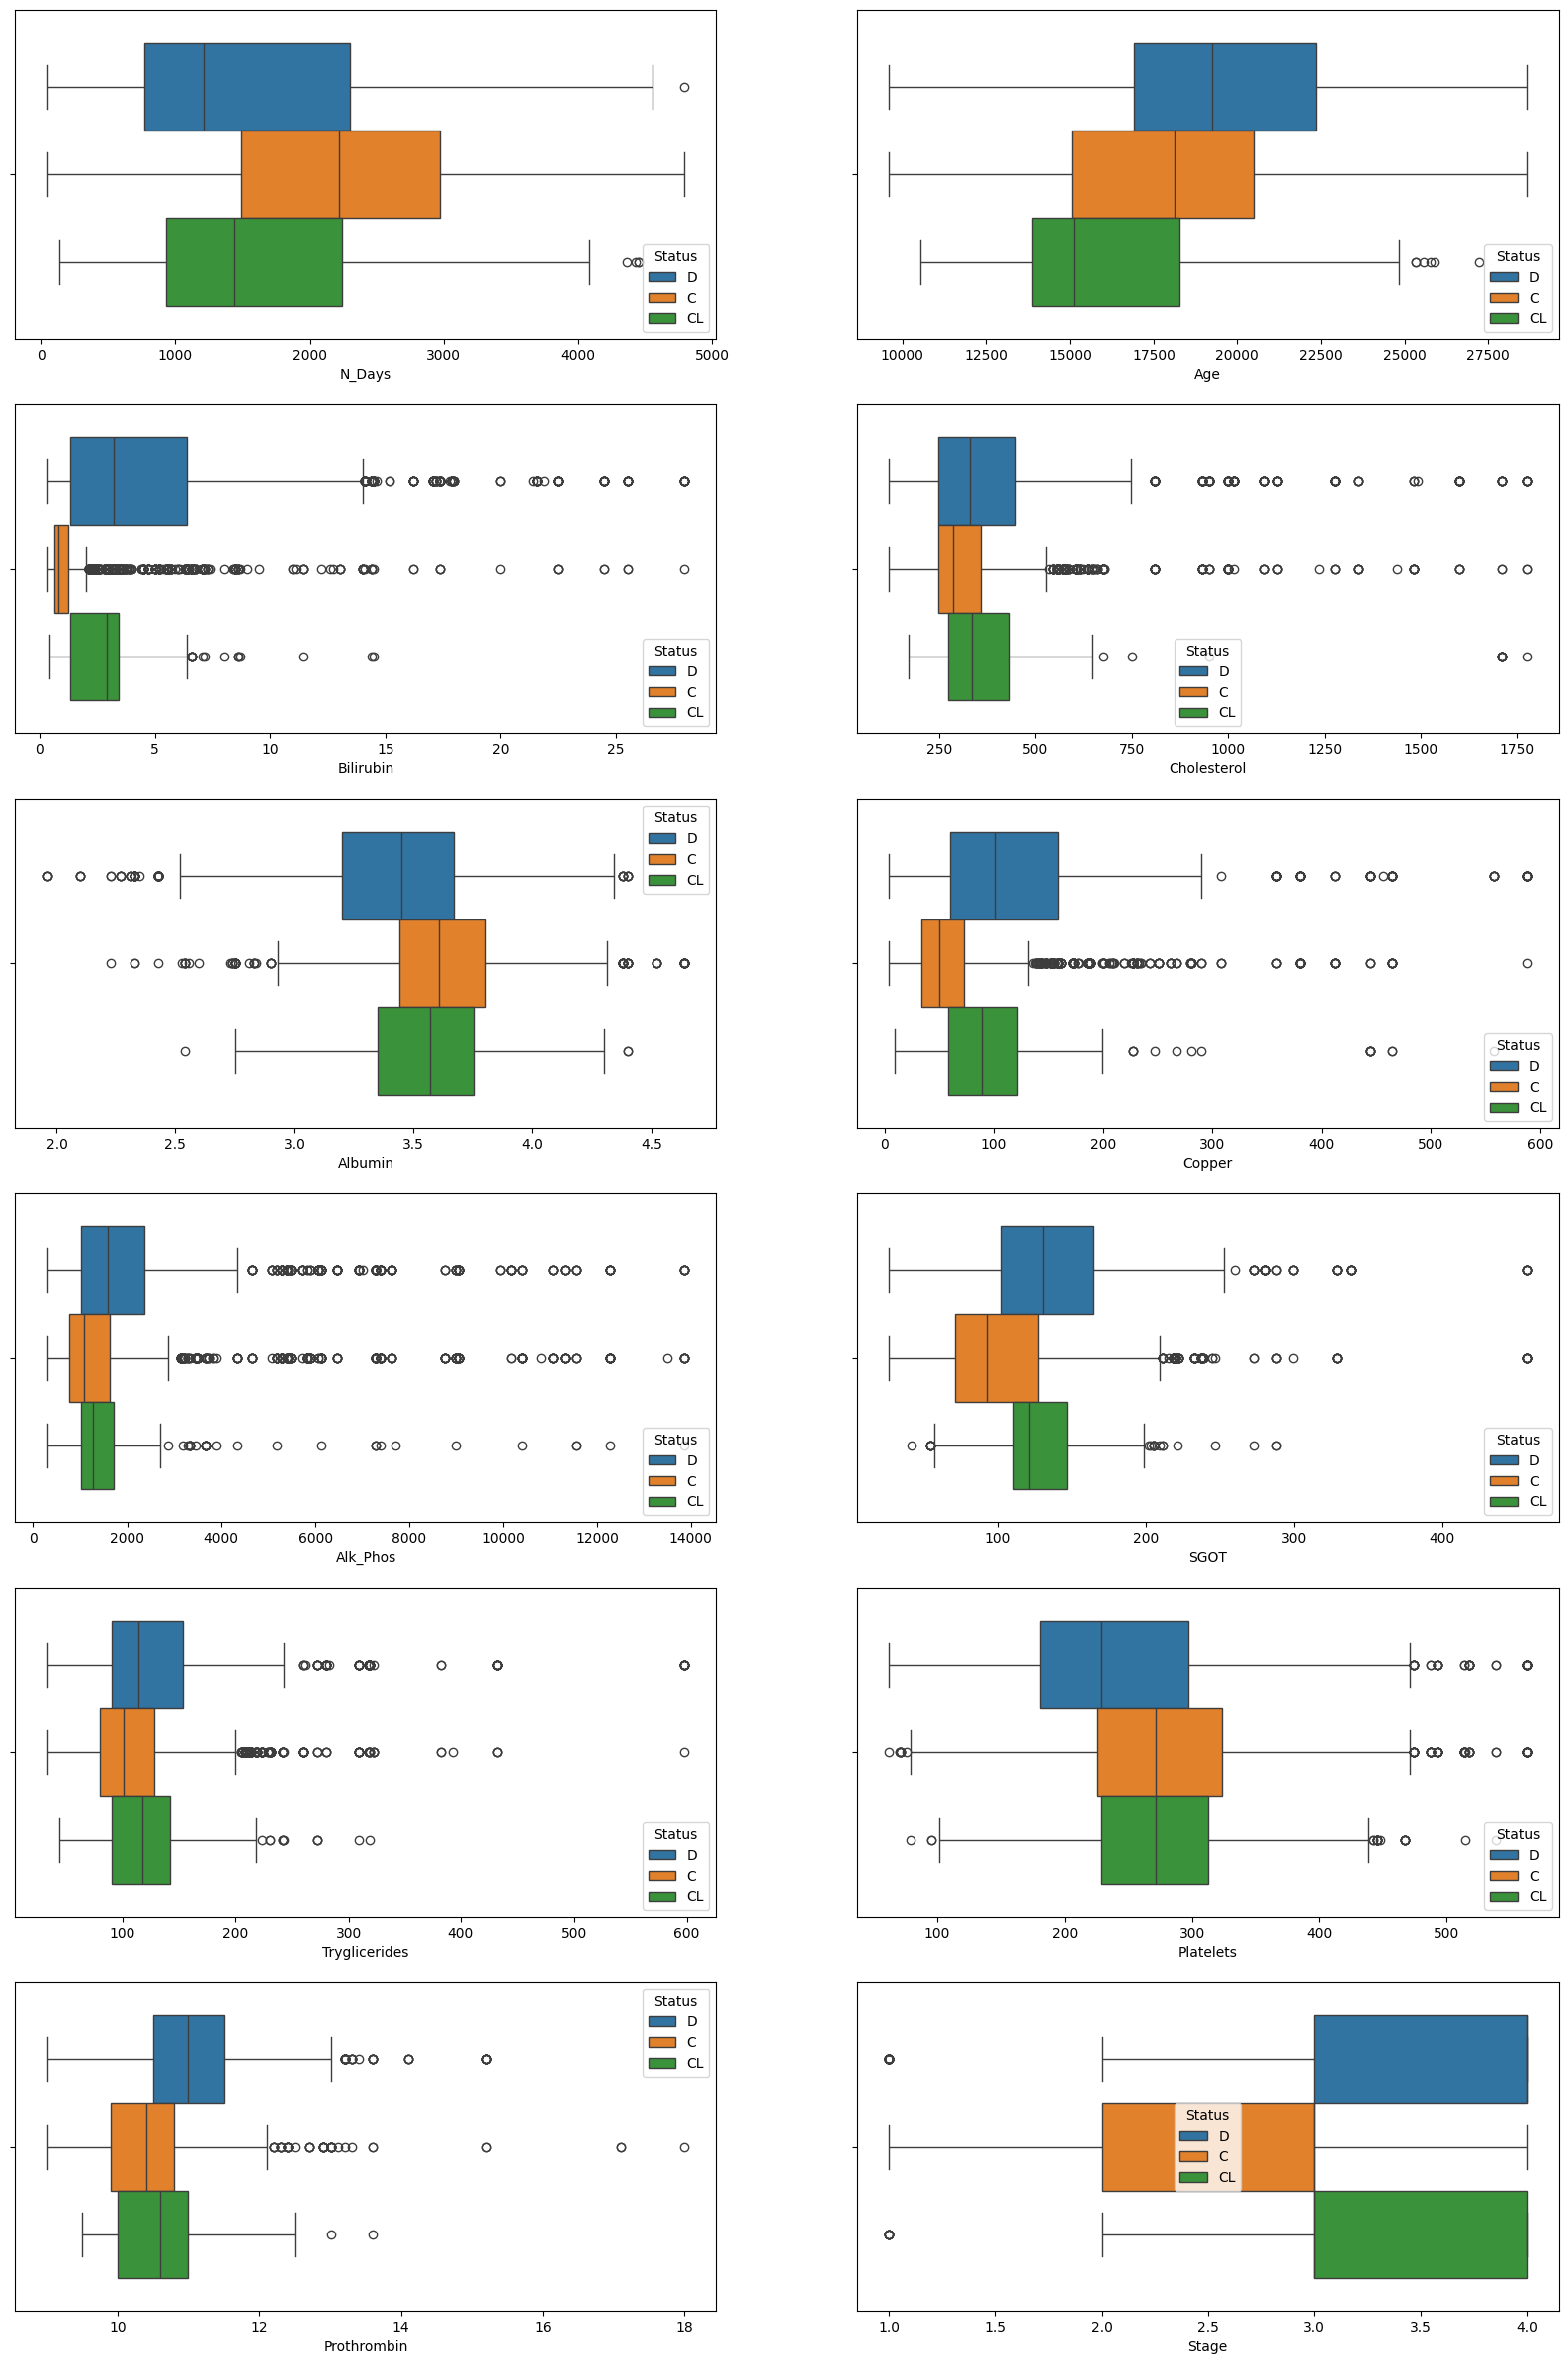

In [8]:
# finding features with outliers
nonobject_features = [feature for feature in df_train.columns[1:] if df_train[feature].dtype != 'object']

fig, axes = plt.subplots(6,2, figsize=(20,30))

for feature, ax in zip(nonobject_features, axes.flatten()):
    sns.boxplot(data=df_train, x=feature, hue='Status', ax=ax)

plt.show()

In [9]:

def remove_outlier(df, feature, threshold=3):
    """ function to remove outliers from a given dataframe

    Args: 
        df: dataframe to remove outliers from
        feature: the feature that we want to remove outliers for
        threshold: the threshold for outlier removal. Sample's with value greater than threshold*z_score or
                    smaller that -threshold*z_score will be removed. The default value is 3.

    Returns:
        df_cleaned: dataframe without outliers
    """

    # Calculate the z-score for the feature of each sample
    z = np.abs(stats.zscore(df[feature]))

    # Identify outliers as samples with a z-score greater than 3
    outliers = df[z > threshold]

    df_cleaned = df.drop(outliers.index)

    return df_cleaned

# features to remove outliers based on the plots
outlier_features = ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
for feature in outlier_features:
    df_cleaned = remove_outlier(df_train, feature)
    df_train = df_cleaned

<Axes: >

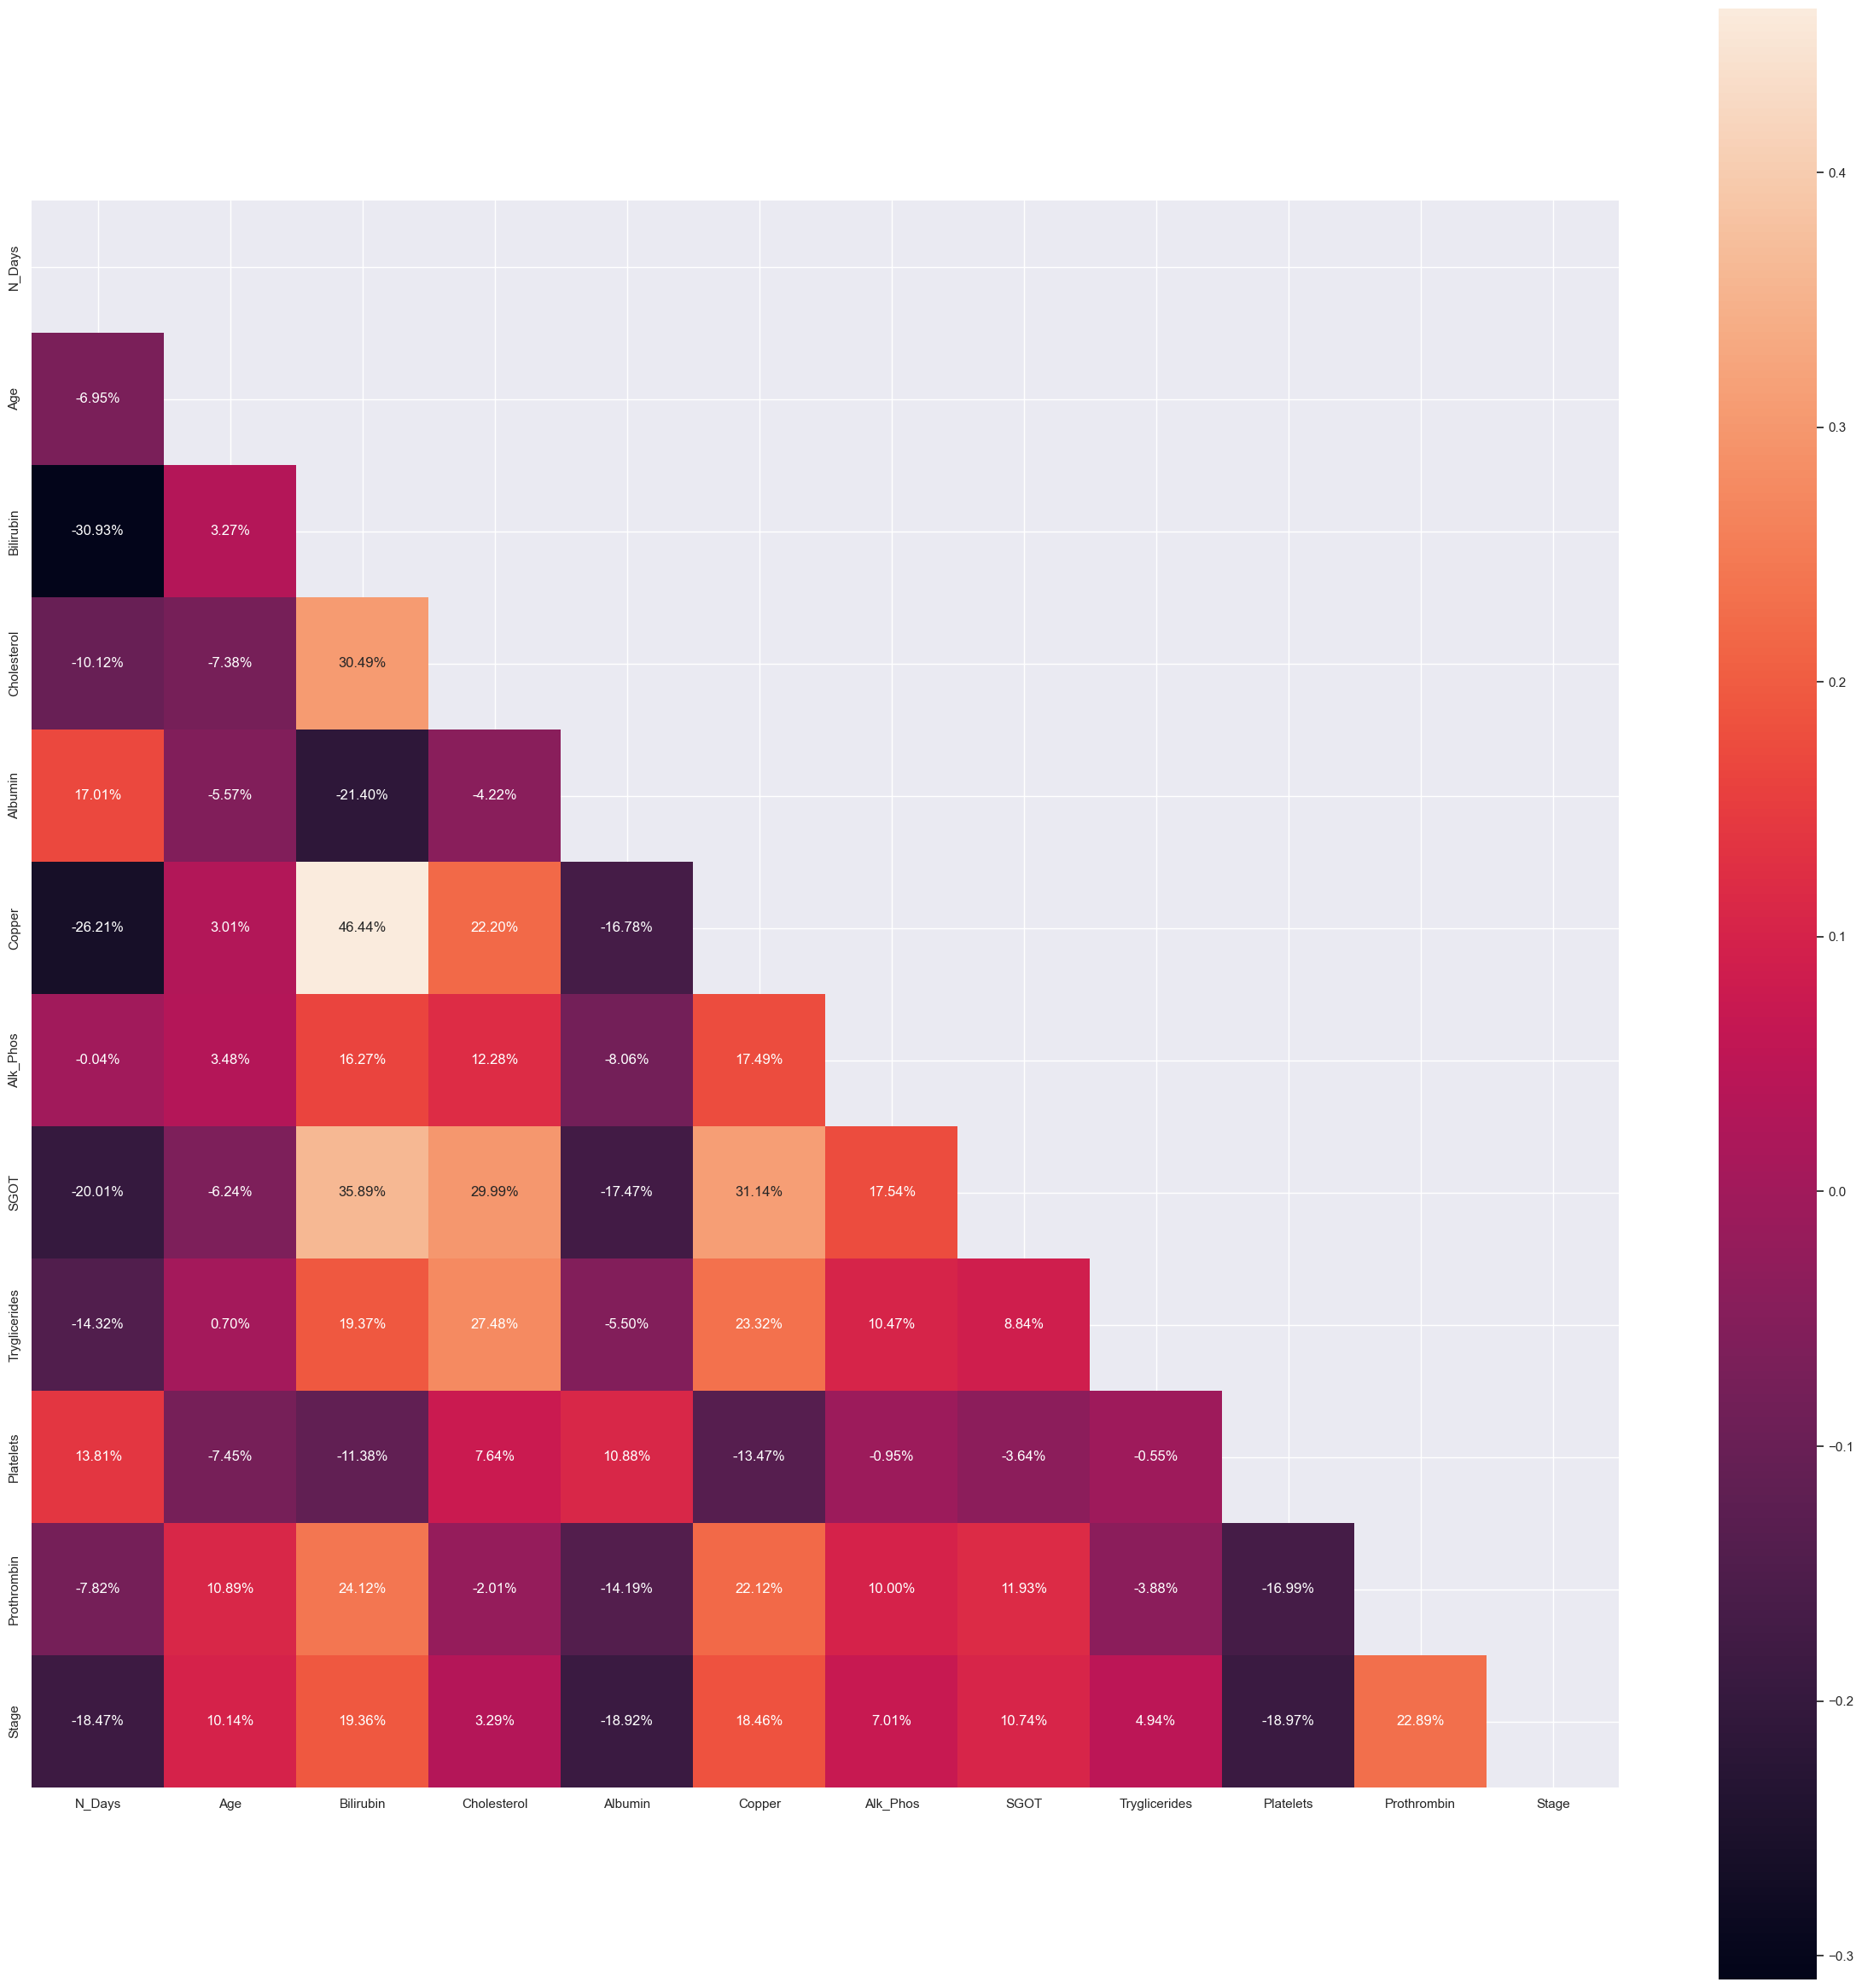

In [10]:
# visualize the correlations
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_train[nonobject_features].corr(), dtype=bool))
sns.set(rc={'figure.figsize':(30, 30)})
sns.heatmap(data=df_train[nonobject_features].corr(), mask=mask, annot=True, fmt=".2%", square=True)

In [11]:
df_train.drop(columns=['id'], axis=1, inplace=True)
df_test.drop(columns=['id'], axis=1, inplace=True)

# # Get one hot encoding of Drug column 
# one_hot = pd.get_dummies(df_train['Drug'], dtype='int', drop_first=True)

# # drop Drug column and insert one hot encoding to df_train
# df_train.drop('Drug', axis=1, inplace=True)
# df_train = pd.concat([df_train.iloc[:, :-1], one_hot, df_train['Status']], axis=1).reset_index(drop=True)

# converting binary and categorical to numeric format for train data
df_train['Drug'].replace(['D-penicillamine', 'Placebo'], [0, 1], inplace=True)
df_train['Sex'].replace(['F', 'M'], [0, 1], inplace=True)
df_train['Ascites'].replace(['N', 'Y'], [0, 1], inplace=True)
df_train['Hepatomegaly'].replace(['N', 'Y'], [0, 1], inplace=True)
df_train['Spiders'].replace(['N', 'Y'], [0, 1], inplace=True)

# converting ordinal features to numeric format for ordinal features for train data
ord = OrdinalEncoder()
df_train['Stage'] = ord.fit_transform(df_train[['Stage']]).astype(int)
df_train['Status'] = ord.fit_transform(df_train[['Status']]).astype(int)
df_train['Edema'] = ord.fit_transform(df_train[['Edema']]).astype(int)

# converting binary categories to numeric format for test data
df_test['Drug'].replace(['D-penicillamine', 'Placebo'], [0, 1], inplace=True)
df_test['Sex'].replace(['F', 'M'], [0, 1], inplace=True)
df_test['Ascites'].replace(['N', 'Y'], [0, 1], inplace=True)
df_test['Hepatomegaly'].replace(['N', 'Y'], [0, 1], inplace=True)
df_test['Spiders'].replace(['N', 'Y'], [0, 1], inplace=True)

# converting ordinal features to numeric format for ordinal features for test data
df_test['Stage'] = ord.fit_transform(df_test[['Stage']]).astype(int)
df_test['Edema'] = ord.fit_transform(df_test[['Edema']]).astype(int)

df_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,0,21532,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,2,2
1,2574,1,19237,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,2,0
2,3428,1,13727,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,3,2
3,2576,1,18460,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,2,0
4,788,1,16658,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,3,0


In [12]:
# scaling the features with wide ranges (N_Days, Age, Bilirubin, Cholesterol, Albumin, Copper, Alk_Phos, SGOT, Tryglicerides, Platelets, Prothrombin)
# choosing the features which are going to be scaled
scaled_columns = df_train.columns.to_list()[0:1] + df_train.columns.to_list()[2:3] + df_train.columns.to_list()[8:-2]

# defining the scaler
ct = ColumnTransformer([('scaler', StandardScaler(), scaled_columns)], remainder='passthrough', verbose_feature_names_out=False)

# scale train data
df_scaled = pd.DataFrame(ct.fit_transform(df_train), columns=ct.get_feature_names_out())
df_train.reset_index(drop=True, inplace=True)
df_train[scaled_columns] = df_scaled[scaled_columns]

# scale test data
df_test_scaled = pd.DataFrame(ct.fit_transform(df_test), columns=ct.get_feature_names_out())
df_test.reset_index(drop=True, inplace=True)
df_test[scaled_columns] = df_test_scaled[scaled_columns]

df_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,-1.059676,0,0.920181,1,0,0,0,0,0.266847,-0.026418,-0.781155,1.924776,0.052725,1.705841,-1.133133,1.559738,-1.258397,2,2
1,0.417469,1,0.285265,0,0,0,0,0,-0.443273,0.427816,-0.151234,-0.149884,-0.071576,0.624632,-0.506599,1.160730,0.704304,2,0
2,1.218410,1,-1.239088,0,0,1,1,2,0.774076,-0.187292,-0.118080,1.144399,-0.388890,0.251801,-1.458931,-0.798036,1.761144,3,2
3,0.419345,1,0.070306,0,0,0,0,0,-0.595441,-0.594210,-0.283849,-0.245052,0.092871,-0.903975,-0.306108,0.048345,0.251373,2,0
4,-1.257566,1,-0.428221,0,0,1,0,0,-0.341827,0.257479,0.213457,-0.149884,-0.271538,0.400933,-0.306108,0.398988,0.100396,3,0


Text(0.5, 1.0, 'Mutual Information Scores')

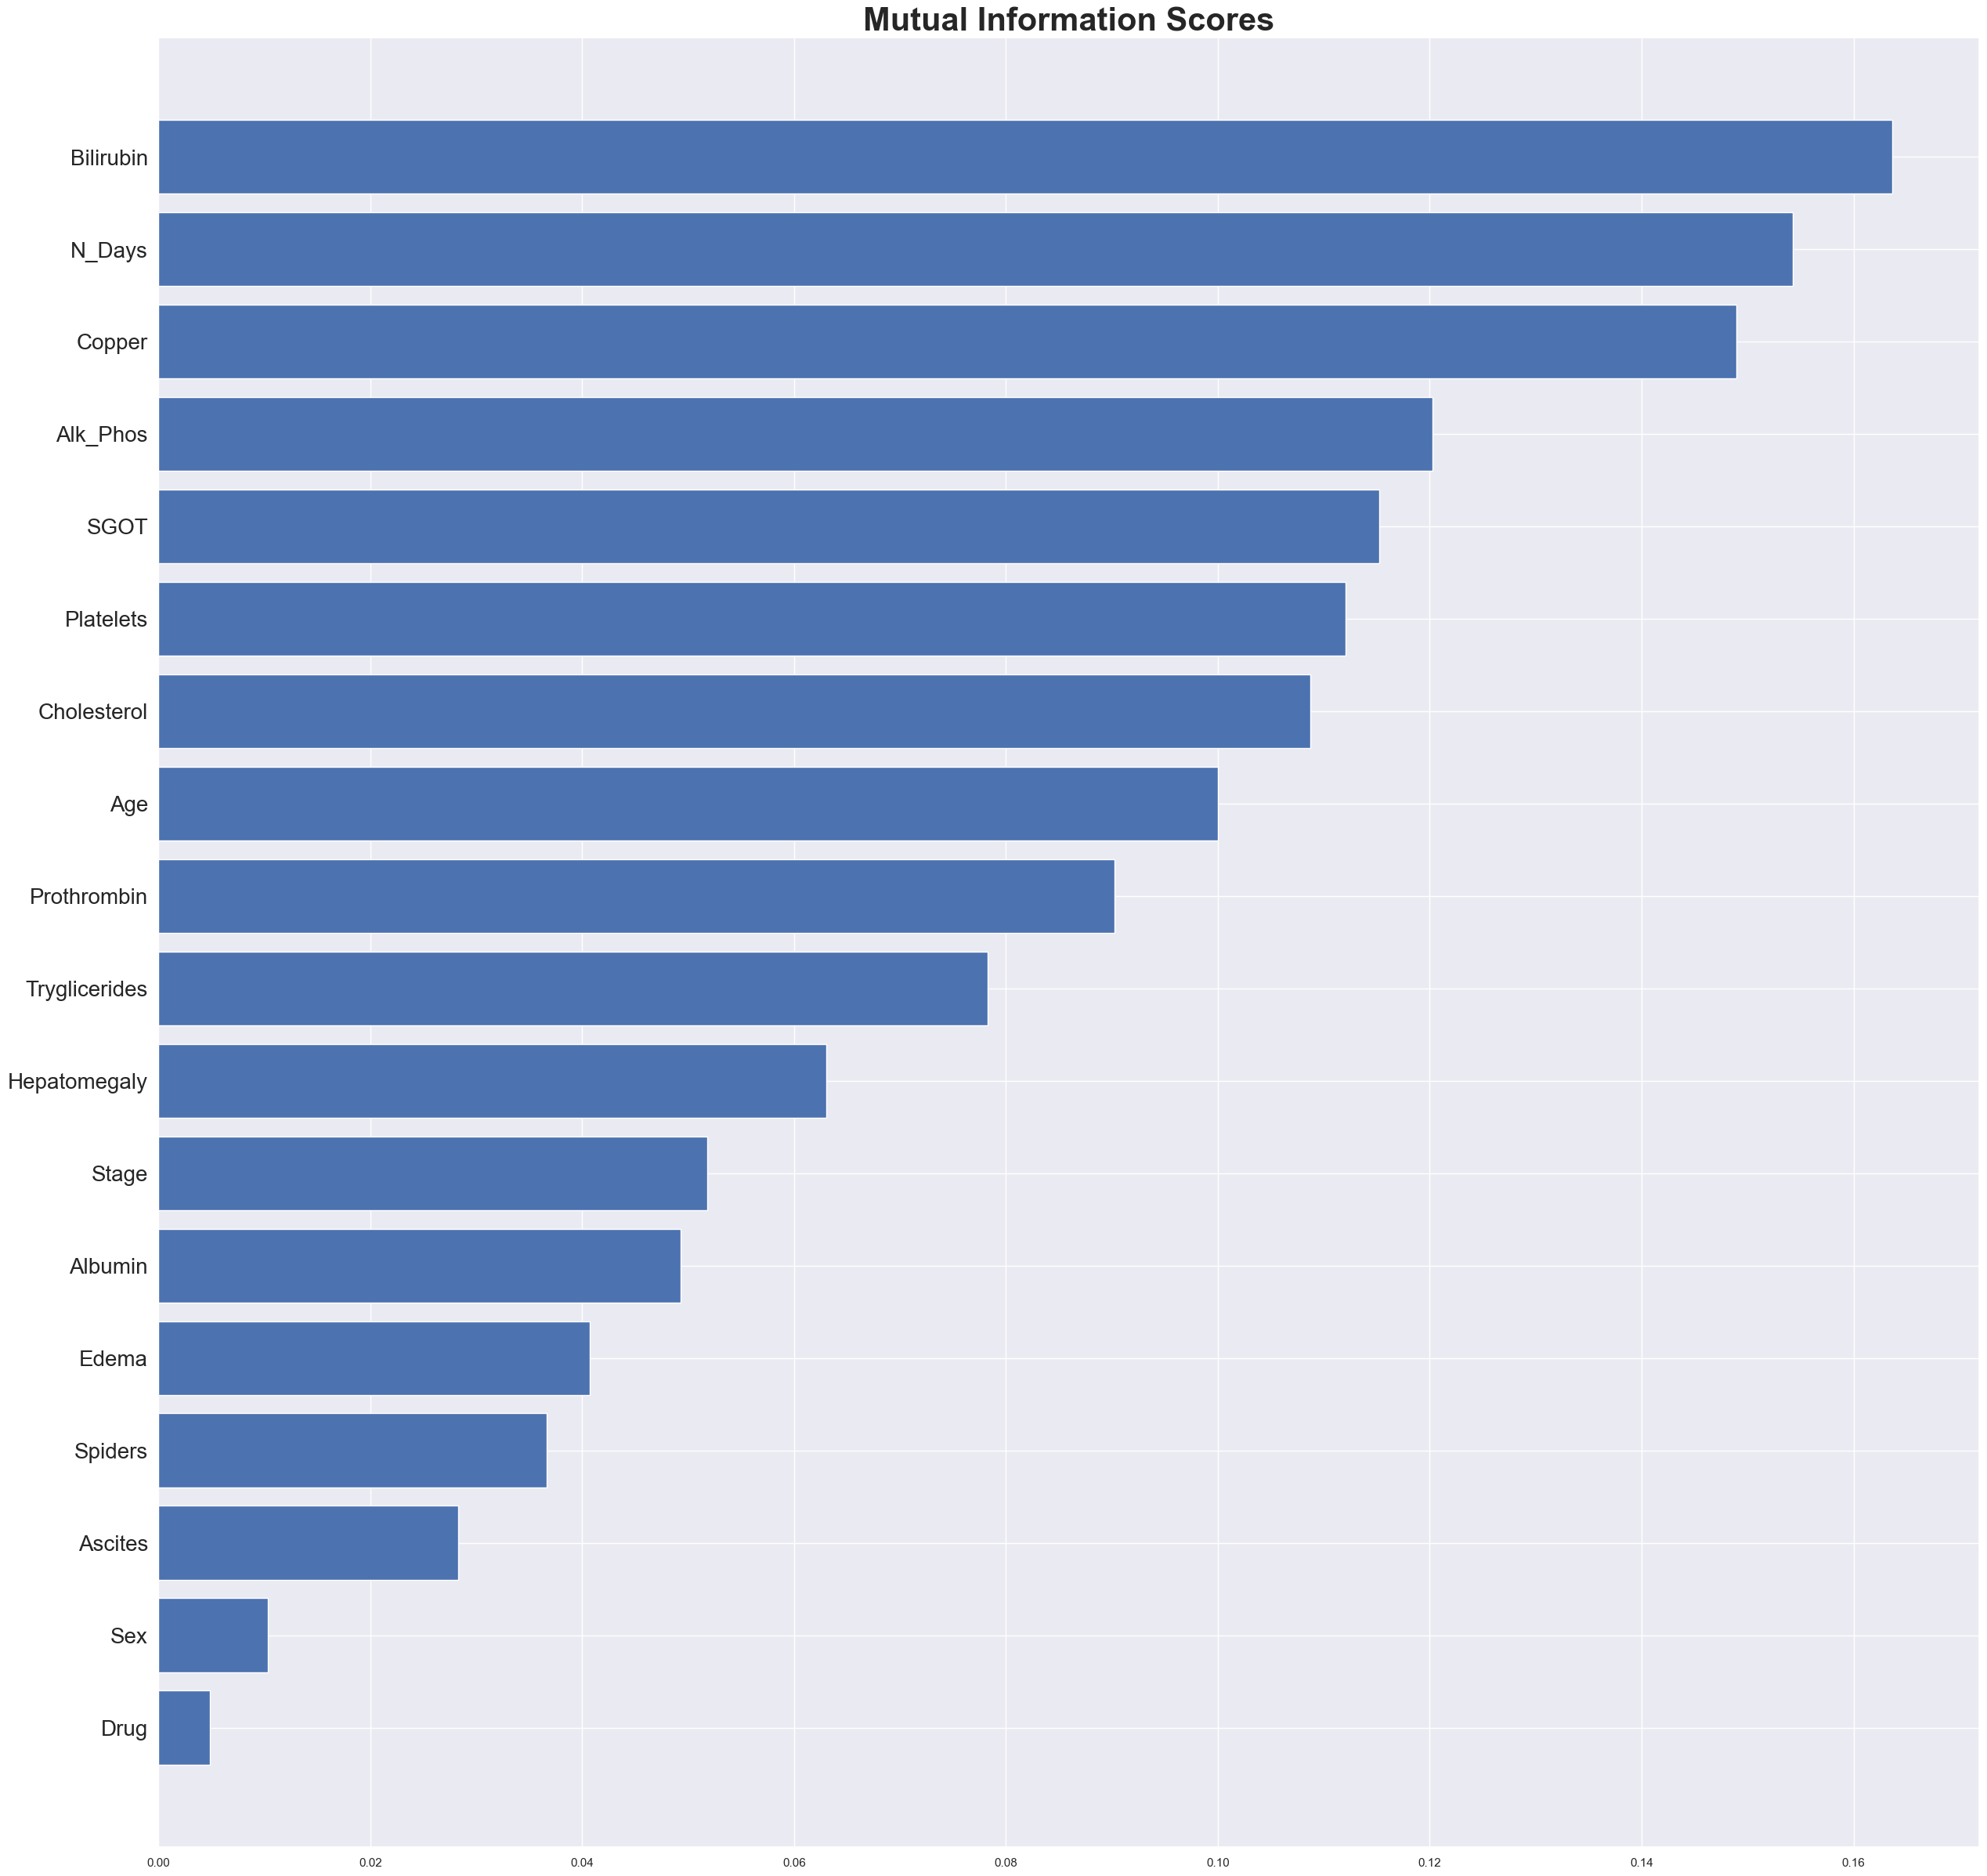

In [13]:
from sklearn.feature_selection import mutual_info_regression

discrete_features = df_train.iloc[:,:-1].dtypes == int
mi_scores = mutual_info_regression(df_train.iloc[:,:-1], df_train['Status'], discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=df_train.iloc[:,:-1].columns)

scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks, fontsize=20)
plt.title('Mutual Information Scores', fontsize=30, fontweight='bold')


In [64]:
X_train = df_train.drop(columns=['Status'], axis=1)
y_train = df_train['Status']

# defining RepeatedStratifiedKFold as our cross validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [65]:
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'n_estimators': 1000,
        'verbosity': 0,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
    }

    model = XGBClassifier(random_state=42, **params)

    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_log_loss').mean()

    return score

In [67]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print('Best params:', best_params)

[W 2023-12-19 15:43:09,850] Trial 0 failed with parameters: {'learning_rate': 0.05638726381710306, 'max_depth': 10, 'subsample': 0.19786613073406367, 'colsample_bytree': 0.7368459777786208, 'min_child_weight': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/8_/ppyc4jb57hb43k7v8vjxl_m00000gn/T/ipykernel_98110/3382760719.py", line 15, in objective
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_log_loss').mean()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
              

KeyboardInterrupt: 

In [63]:
optuna.visualization.plot_param_importances(study)

In [28]:
# Train the model with the best hyperparameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

0.8322448511631786